Student: Juliana Carvalho de Souza
M2 MASH

Practical Session 2 - Deep Learning for Image Analysis

# Classifying digits using a fully connected neural network

In this practical exercice a fully connected neural network (also called multi-layer perceptron) is built using keras. It is then trained to classify image digits from the MNIST database. The MNIST database is a set of 28x28 grey-level, centered images of digits.

Some baseline results:

| Method                                                                      | Test error (%) |
|-----------------------------------------------------------------------------|---------------:|
| Linear classifier (LeCun et al. 1998)                                       |           12.0 |
| K-nearest-neighbors, Euclidean (L2) (LeCun et al. 1998)                     |            5.0 |
| 3-layer NN, 500-300, softmax, cross entropy, weight decay (Hinton, 2005)    |            1.5 |
| Convolutional net LeNet-4 (LeCun et al. 1998)                               |            1.1 |
| Virtual SVM deg-9 poly [data augmentation] (LeCun et al. 1998)              |            0.8 |
| 6-layer NN with [data augmentation] (Ciresan et al. 2010)                   |           0.35 |
| Deep conv. net, 7 layers [data augmentation] (Ciresan et al. IJCAI 2011)    |           0.35 |

More results are available from: http://yann.lecun.com/exdb/mnist/

Try to improve on some of these results, at least on those that do not use data augmentation or convolutional neural networks.

Teaching assistant: romain.vo@mines-paristech.fr

## Package imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.python.keras import backend as K
from tensorflow.keras.datasets import mnist as db
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

# Magic used by the notebook to show figures inline
%matplotlib inline
# matplotlib default values
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading packages
%load_ext autoreload
%autoreload 2


## Data

The MNIST dataset is a widely used baseline for classifcation, and deep learning methods specifically, and as such is directly available through the keras API. The data is split in training and test set.

In [2]:
# Load the data
(x, y), (x_test_ori, y_test_ori) = db.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## First look

Have a look at the data. You can run the next cell several times to have a look at different instances of the same class.

**#i** here denotes the number of samples which belongs to the class **i**.

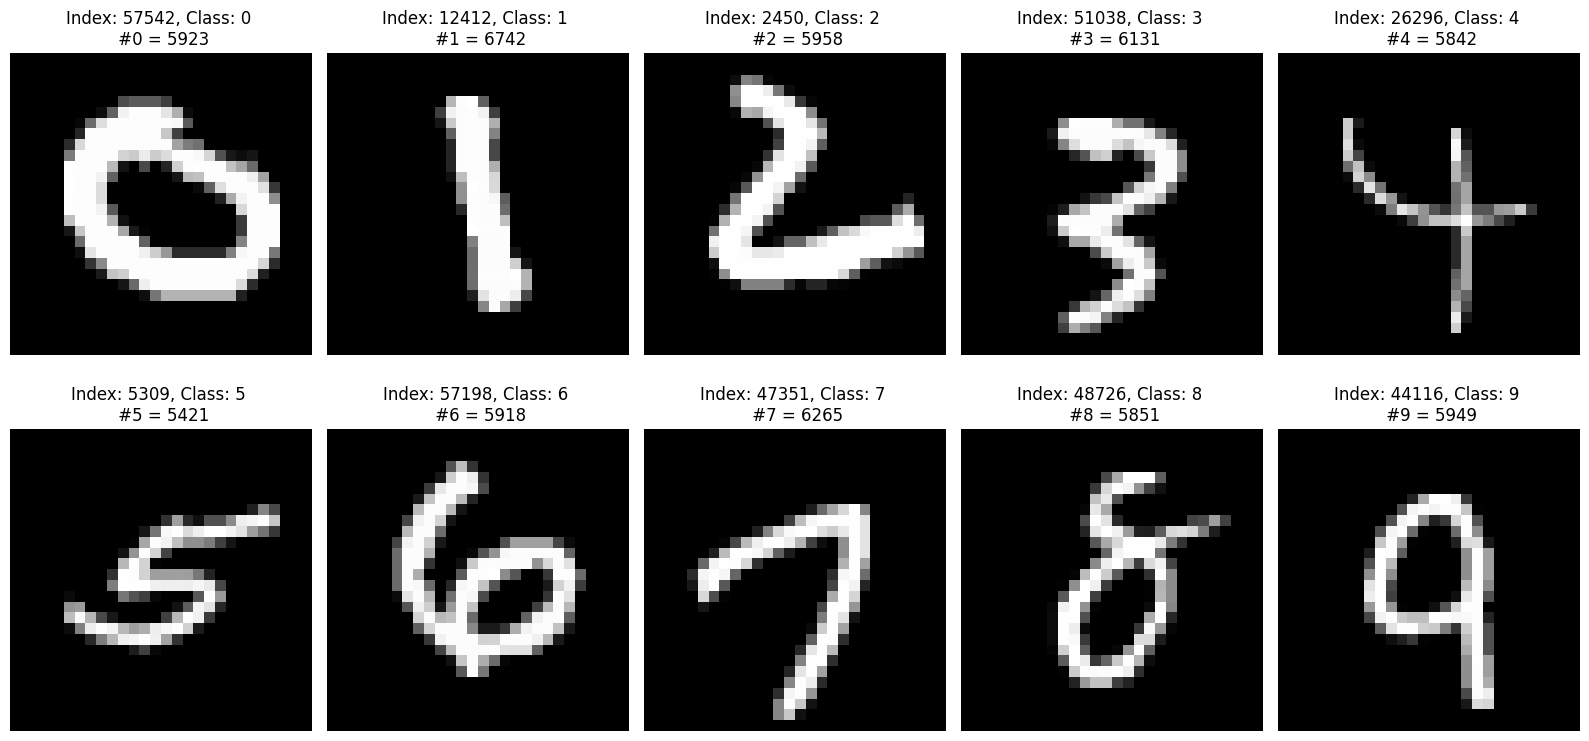

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16,8))
ax = ax.reshape(-1)

for i in range(10):
    class_mask = np.nonzero(y == i)[0]
    index = np.random.choice(class_mask)
    ax[i].imshow(x[index])
    ax[i].axis('off')
    ax[i].set_title(f"Index: {index}, Class: {y[index]} \n #{y[index]} = {class_mask.shape[0]}")

fig.tight_layout()

### Data preparation

<u>Splitting :</u> The training subset of the MNIST database contains 60000 images. We will split this set into an effective training set (90%) and a validation set (10%). This will allow us to improve our model without looking at the test set. As a rule of thumb the test should be evaluated very very few times, only when you think you have reach the end of your improvement procedure.

<u>Normalization :</u> We need to normalize the data before feeding it to the neural network, this is done simply by dividing the pixel values by 255.

<u>Formatting the input:</u> For the moment, the training data (the images) are stored in 2D arrays. Because we are using *Fully connected layers* (**FCL**), also called *Multi-Layer Perceptron* (**MLP**), we only need 1D vector as input. Thus we flatten the 2D arrays beforehand.
- `x[idx].shape = (28,28)`  $\rightarrow$  `x[idx].shape = (784)`

<u>Formatting the output:</u> For the moment, the target is simply stored by assigning to each index of the `y` array, the corresponding digit value. Here our future **MLP** will compute an `output` tensor of 10 "probabilities" (between 0 and 1) for each image. Thus for an image of the digit `8` we would like `output[7]` to be equal to 1. To learn such a network we also need to format the `y` array into a relevant encoding. So we apply a *one-hot encoding* to each value stored in `y` :
- `y[idx] = 8`  $\rightarrow$  `y[idx] = [0, 0, 0, 0, 0, 0, 0, 1, 0]`

In [4]:
# Data management
val_nb = 6000  # number of validation samples
nb_samples = x.shape[0]

if val_nb > nb_samples:
    raise ValueError("You need some samples to train your network!")

img_width, img_height = x.shape[1], x.shape[2]

num_of_pixels = img_width * img_height

# As we are using only fully connected layers, we need a vector as input
x = x.reshape(nb_samples, num_of_pixels)
x_test = x_test_ori.reshape(x_test_ori.shape[0], num_of_pixels)

# Normalization
x = x.astype('float32')
x_test = x_test.astype('float32')
x /= 255
x_test /= 255

x_val = x[:val_nb, ]
x_train = x[val_nb:, ]
y_val = y[:val_nb]
y_train = y[val_nb:]

# one-hot encoding of classes
num_classes = max(y) + 1
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test_ori, num_classes)


print(x_train.shape, 'x train samples')
print(x_val.shape, 'x val samples')
print(x_test.shape, 'x test samples')
print(y_train.shape, 'y train samples')
print(y_val.shape, 'y val samples')
print(y_test_ori.shape, 'y test samples')

(54000, 784) x train samples
(6000, 784) x val samples
(10000, 784) x test samples
(54000, 10) y train samples
(6000, 10) y val samples
(10000,) y test samples


## First model

We will begin with a network containing a single layer. We use a `softmax` activation for our last and single layer in order to normalize the `output` tensor.


In [5]:
# let define a first simple model without any hidden layers
model = Sequential()
model.add(Input(x_train.shape[1:]))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

### Training

The following section takes care of training.

Firstly, the model has to be 'compiled'. This operations lets the user to choose the loss, the optimizer and the metrics, then configures the model for training.

<u>Loss :</u> To train our model we choose a *categorical cross-entropy*, with $N$ the number of samples and $C$ the number of classes:
- $L(y, \hat{y}) = \frac{1}{N} \sum_{i=0}^N \left( - \sum_{c=1}^C y_{i,c} \log(\hat{y}_{i,c}) \right)$  

Implement a categorical cross-entropy using only `K.log`, `K.sum` , `K.mean`

To check that your implement of `categorical_crossentropy` is correct, you should approximately have the same results when setting `loss='categorical_crossentropy'`, which uses the built-in implementation of keras.

<u>Optimization :</u> Secondly, the 'fit' method runs the optimization. Training and validation data are specified here, as well as batch size and the number of epochs.


In [6]:
learning_rate = 0.01

def categorical_crossentropy(target, prediction):
    """
    target : array of shape [batch_size, num_classes]
    prediction : array of shape [batch_size, num_classes]
    """

    ### TO BE IMPLEMENTED ###

    #########################
    log_pred = K.log(prediction)
    sum_yhat = K.sum(target * log_pred, axis=1)
    return K.mean(-sum_yhat)

model.compile(loss=categorical_crossentropy,
              optimizer=SGD(learning_rate=learning_rate),
              metrics=['accuracy'])


Note that you can run the cell below several times. Training will restart from the point it stopped in the previous run. However variable *output* will only contain the history of the last run.

In [8]:
batch_size = 128
epochs = 10
output = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val, y_val))

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5067 - loss: 1.7256 - val_accuracy: 0.8193 - val_loss: 0.8525
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8259 - loss: 0.7982 - val_accuracy: 0.8532 - val_loss: 0.6352
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8479 - loss: 0.6366 - val_accuracy: 0.8690 - val_loss: 0.5467
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8616 - loss: 0.5619 - val_accuracy: 0.8773 - val_loss: 0.4972
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8692 - loss: 0.5174 - val_accuracy: 0.8840 - val_loss: 0.4642
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8758 - loss: 0.4846 - val_accuracy: 0.8878 - val_loss: 0.4409
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8796 - loss: 0.4657 - val_accuracy: 0.8915 - val_loss: 0.4234
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8826 - loss: 0.4504 - val_accuracy: 0.

### Is training satisfactory?

Looking at the evolution of training and validation accuracies, one can evaluate the quality of training.

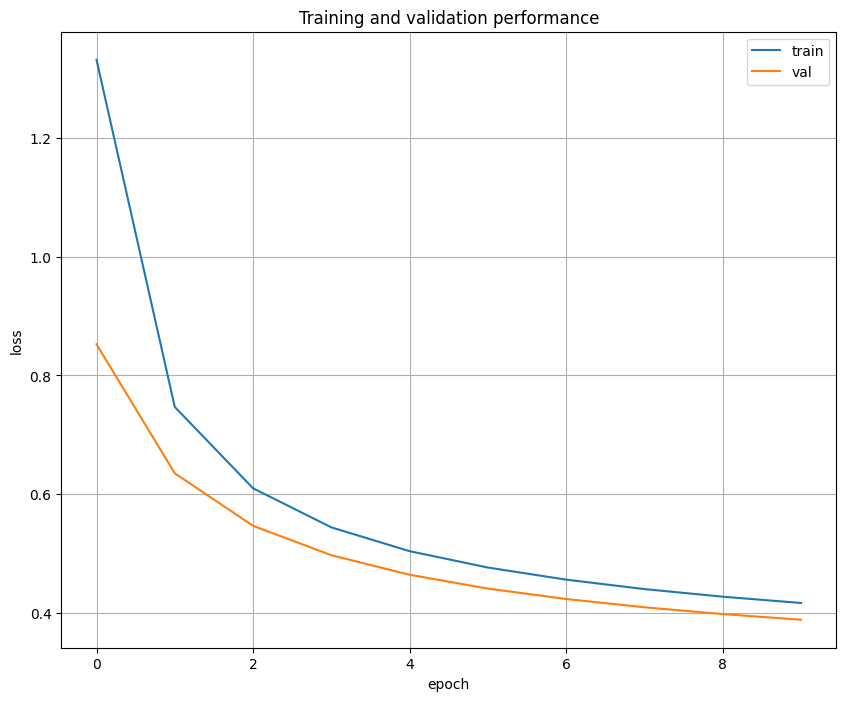

In [9]:
plt.plot(output.epoch, output.history['loss'], label='train')
plt.plot(output.epoch, output.history['val_loss'], label='val')
plt.title('Training and validation performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()

### Questions



*   Do you think learning could be improved? Why?

**Answer**:

Yes. Firstly, we should run the model for more epoches.  We also could use an optmizer that converges more quickly, such as Adam, instead of SGD, and test different (possibly smaller) learning rate.

*   Is there overfitting? Why?

**Answer**:

No, the graph do not show overfitting as the trainning loss is greater than validation loss. Both training and validation loss decrease over time, and they appear to follow a similar trend without a major gap. Overfitting typically occurs when the training loss continues to decrease, but the validation loss either plateaus or starts to increase, indicating that the model is learning the training data too well but failing to generalize to new data.


In [11]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

Test loss: 0.389
Test accuracy: 0.899


### Analysis of the weights

With this simple model it is possible to have an intuition of what the neural network has learned looking at
the matrix of the weights $W$.
In fact $W\in\mathbb{R}^{784\times 10}$, so for each class $i$ we can plot the weights corresponding to this class.

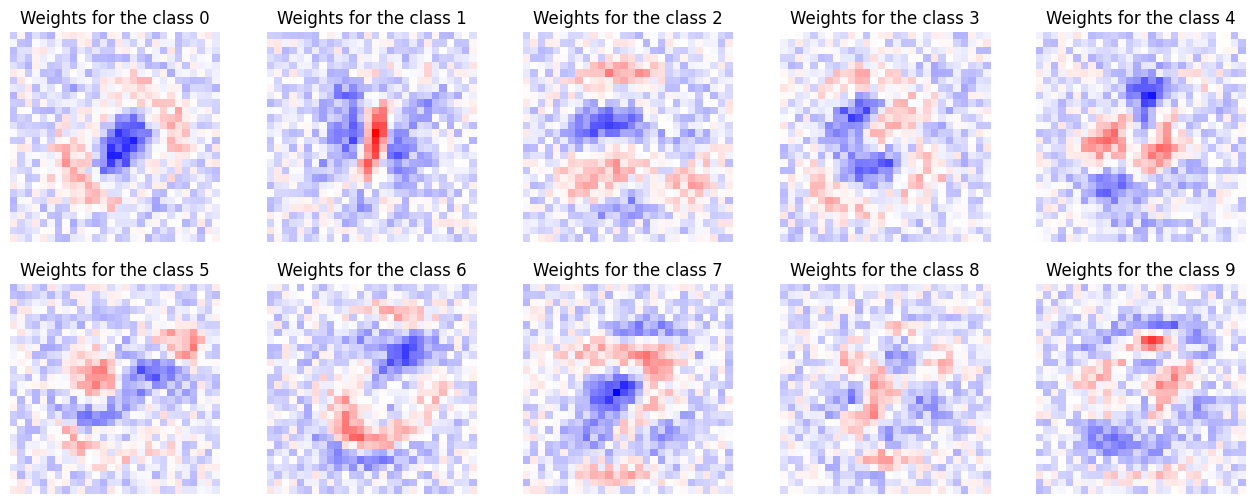

In [12]:
# plotting the weights
W, b = model.layers[0].get_weights()
vmin = W.min()
vmax = W.max()
f, ax = plt.subplots(2, 5, figsize=(16,6))
for plt_row in range(2):
    for plt_col in range(5):
        ax[plt_row][plt_col].imshow(W[:,plt_row*5 + plt_col].reshape(img_width,img_height), vmin=vmin, vmax=vmax, cmap=plt.cm.bwr)
        ax[plt_row][plt_col].axis('off')
        ax[plt_row][plt_col].set_title("Weights for the class {}".format(plt_row*5 + plt_col))
        # add scale for the colors, with values

plt.show()

## Improving performance by adding extra layers

In order to improve the performances of our prediction it is possible to add hidden layers between the input layer and the output layer.

Note that here we are restricted to dense layers. Do not use (yet) other types of layers.

In [13]:
model = Sequential()
model.add(Input(x_train.shape[1:]))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax', name="last"))

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ last (Dense)                         │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
learning_rate = 0.01
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=learning_rate),
              metrics=['accuracy'])

In [15]:
batch_size = 64
epochs = 40
output = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val, y_val),
)

Epoch 1/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5543 - loss: 1.5400 - val_accuracy: 0.8893 - val_loss: 0.4363
Epoch 2/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8877 - loss: 0.4199 - val_accuracy: 0.9143 - val_loss: 0.3198
Epoch 3/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9071 - loss: 0.3271 - val_accuracy: 0.9235 - val_loss: 0.2762
Epoch 4/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9167 - loss: 0.2940 - val_accuracy: 0.9312 - val_loss: 0.2526
Epoch 5/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9245 - loss: 0.2628 - val_accuracy: 0.9360 - val_loss: 0.2338
Epoch 6/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9304 - loss: 0.2455 - val_accuracy: 0.9390 - val_loss: 0.2193
Epoch 7/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9325 - loss: 0.2347 - val_accuracy: 0.9422 - val_loss: 0.2044
Epoch 8/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9381 - loss: 0.2126 - val_accuracy: 0.

### Analysis of the results




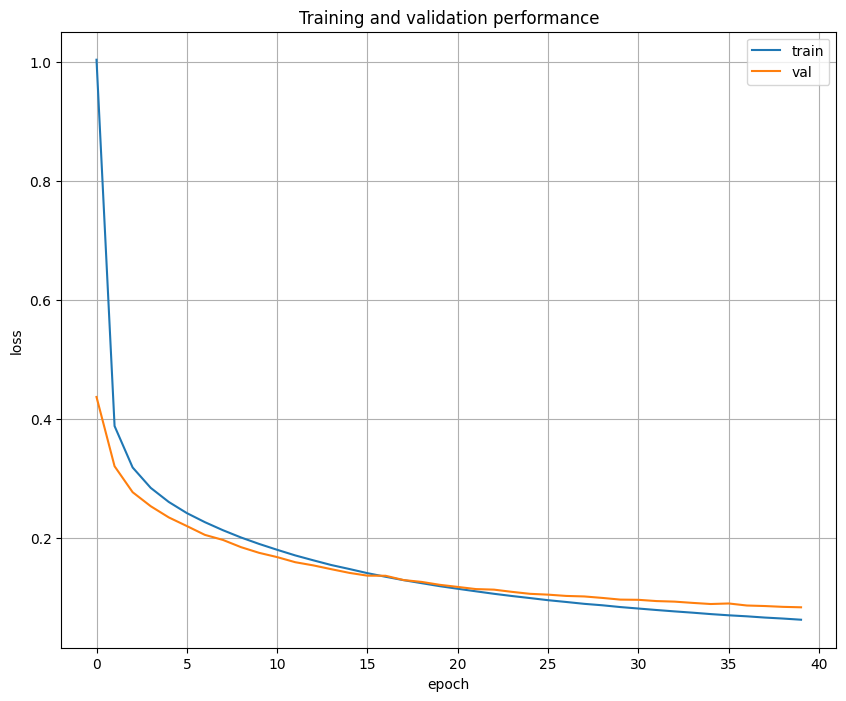

In [16]:
plt.plot(output.epoch, output.history['loss'], label='train')
plt.plot(output.epoch, output.history['val_loss'], label='val')
plt.title('Training and validation performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()
# plt.ylim(0.2, 0.8)

Is there overfitting? How can it be reduced?

**Answer**:

Yes, because trainnng error started to decreasing while validation is increasing. It could be avoided with regularization (for exemple, in the adding a Ridge or Lassso loss to take into account weights of parameters).

In [17]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

Test loss: 0.087
Test accuracy: 0.973


### Qualitative error analysis

Let us have a look at some images that have been incorrectly classified.

<u>Inference </u>: We call the `predict` method on our model and feed the `x_test` array to obtain the probabilities for each test sample. The `y_predict_proba` is a *one-hot encoded* array so we compute the index of the maximum predicted probability to extract the label of the predicted digit

In [18]:
y_predict_proba = model.predict(x_test)
y_predict = np.argmax(y_predict_proba, 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


You can run the following cell several times to inspect different errors, or manually change the `index` variable

In [19]:
rng = np.random.default_rng(0)

Correct label is: 4
Predicted label is: 2 with a "probability" of 61.41%
Label 4 was predicted with a "probability" of 7.05%

Probabilities: [2.1199574e-04 2.3297548e-04 6.1410612e-01 6.8585002e-03 7.0474096e-02
 5.2836712e-04 3.0711001e-01 2.3828856e-04 2.3823458e-04 1.4389377e-06]


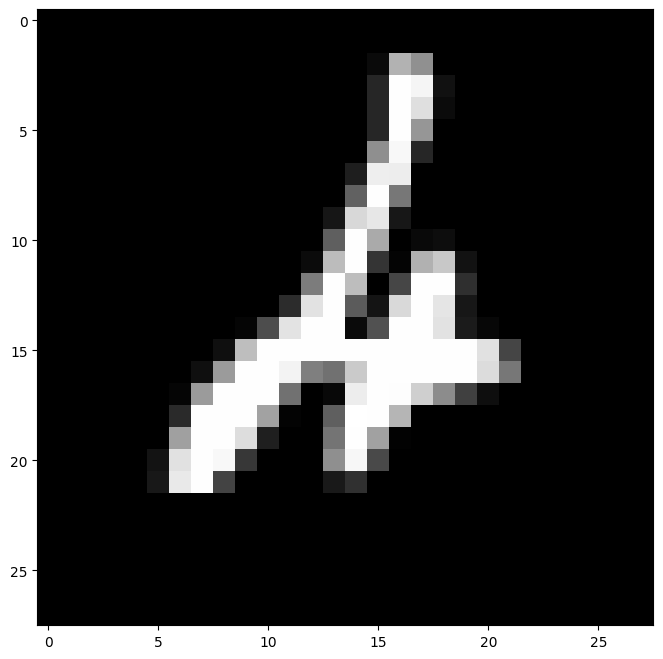

In [20]:
err_mask = y_test_ori != y_predict
ok_mask = y_test_ori == y_predict

x_test_errors = x_test_ori[err_mask]
y_test_errors = y_test_ori[err_mask]
y_predict_errors = y_predict[err_mask]
y_predict_proba_errors = y_predict_proba[err_mask]
y_predict_proba_ok = y_predict_proba[ok_mask]

# index = rng.choice(range(y_test_errors.shape[0]))
index = 2
print(f"Correct label is: { y_test_errors[index]}")
print(f"Predicted label is: {y_predict_errors[index]} with a \"probability\" of {y_predict_proba_errors[index, y_predict_errors[index]]:.2%}")
print(f"Label {y_test_errors[index]} was predicted with a \"probability\" of {y_predict_proba_errors[index, y_test_errors[index]]:.2%}", end='\n\n')
print(f"Probabilities: {y_predict_proba_errors[index]}")
plt.imshow(x_test_errors[index], cmap="gray")
plt.show()

We can plot the histogram of the probabilities of the predicted classes, given that the predictions are correct or incorrect. This should give us some intuitions on how the network "behaves" during inference

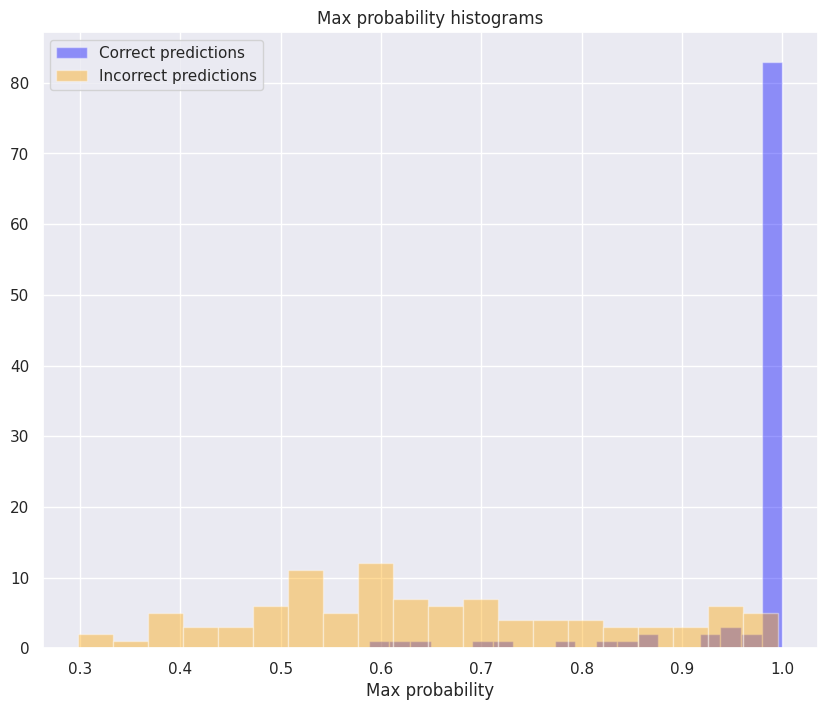

In [21]:
%matplotlib inline

# p.max() keeps the highest probability among the 10 outputs.

max_predictions_correct = np.max(y_predict_proba[ok_mask], 1)
max_predictions_incorrect = np.max(y_predict_proba[err_mask], 1)

# np.random.shuffle shuffles the values of the array
np.random.shuffle(max_predictions_correct)
np.random.shuffle(max_predictions_incorrect)

y_predict_proba_errors.shape

histo_bins = 20
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots()

ax.hist(max_predictions_correct[0:100], density=False,
         bins=histo_bins,
         color="blue",
         alpha=0.4,
         label='Correct predictions')
ax.hist(max_predictions_incorrect[0:100],density=False,
         bins=histo_bins,
         color="orange",
         alpha=0.4,
         label='Incorrect predictions')

ax.set_title('Max probability histograms')
ax.set_xlabel("Max probability")
ax.legend()

sns.reset_defaults()


Is the network 'confident' when making errors?

**Answer**:

Incorrect predictions (orange) are more spread out across lower probabilities, but most of them are above 0.5.
The graph in orange shows that the density of max probability varies much, however, most of them concentrated above 0.5, which is high compared to random estimatives (which for 10 classes would be 0.1). So, the network is giving a high probability for wrong answers, so, yes, it is confident when making errors.

What do you think about these errors?

**Answer**:

The network is being confident when making erros. On the other hand, I think it also have a high cofidence in predicting the right labels (as most of max prob is above 0.9).

### Quantitative error analysis

We can measure the uncertainty of our model by measuring the entropy of its predictions. In [information theory](https://en.wikipedia.org/wiki/Entropy_(information_theory)) the entropy of a random variable is given by $H(X) = - \sum_{x \in \mathcal{X}} p(x) \log\left(p(x)\right)$. In our case we can compute the entropy of a prediction using:
- $H(\hat{y}) = - \sum_{c=1}^C \hat{y}_{c} \log(\hat{y}_{c})$

In [22]:
def entropy(predictions):
    return - np.sum(predictions * np.log(predictions), axis=1)

We will plot the smoothed histogram (Kernel Density Estimation) of our predictions' entropy, given that the predictions are correct or incorrect.

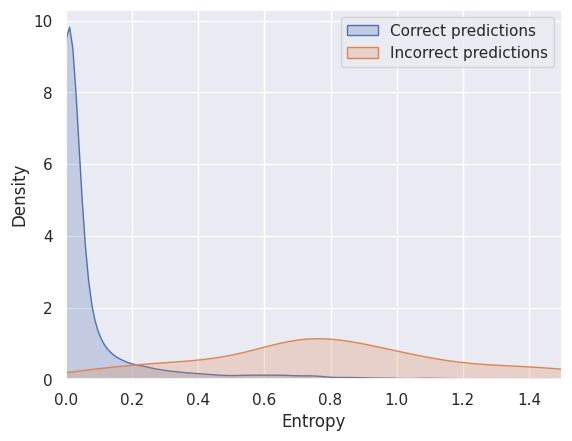

In [23]:
%matplotlib inline
sns.set_theme()

entropies = entropy(y_predict_proba)

fig, ax = plt.subplots()
sns.kdeplot(entropies[ok_mask], label='Correct predictions', ax=ax, fill=True)
sns.kdeplot(entropies[err_mask], label='Incorrect predictions',ax=ax, fill=True)
ax.set_xlim(0, 1.5)
ax.set_xlabel('Entropy')

ax.legend()

sns.reset_defaults()

From this plot what can you say about our model in terms of uncertainty ? Why ?

**Answer**:
Considering the entropy as a measure of confusion and uncertainty, we can see from the graphs that:

- For the incorrect predictions, the highest density is centered around the entropy of 0.8, and the density varies much around the other values. So, the model seems uncertain in the incorrect predictions.

- For the correct prediction, the entropy is concentrated in 0, so it is not very confused.

Very quickly, What kind of prediction would maximize the entropy ?

**Answer**: y = [1/10, 1/10, 1/10, 1/10, 1/10, 1/10, 1/10, 1/10, 1/10, 1/10]

The uniform prediction (1/10).

Based on the analysis of the entropy, design a procedure to estimate beforehand if a prediction will be wrong or not.

What are the limits of your procedure ? You could surely use the following objects do analyze the limits: `entropies, err_mask, ok_mask`

You could use the following objects: `entropies, err_mask, ok_mask`

**Answer**:

Observing the graph, we could estimate a threshold for which we could separate the wrong and correct predictions. To choose the best threshold, we could test different thresholds in the range of the entropy values.

**LIMITS**:
- **Threshold.** The distributions of entropy for correct and incorrect predictions often overlap, as seen in the plot. This means that even if a good threshold is chosen, some predictions will still fall in the overlapping region, making them difficult to classify correctly.

- Entropy reflects uncertainty in the model's prediction. However, **uncertainty does not always imply incorrectness.** A model can be uncertain (high entropy) yet still make the correct prediction, and conversely, it can be overly confident (low entropy) but make the wrong prediction.

- A single static threshold might not generalize well across different datasets, models, or tasks.

- Using a single threshold imposes a binary decision boundary (either above or below the threshold). However, the actual **relationship between entropy and prediction correctness might not be purely binary** and may require a more nuanced approach, such as probabilistic models or dynamic thresholds.


In [24]:
def estimate_wrong_prediction(entropies, threshold=0.8):
  """
  Estimates if a prediction will be wrong based on the entropy.

  Args:
    entropies: entropy for each class.
    threshold: The entropy threshold above which a prediction is considered likely to be wrong.

  Returns:
    A boolean array indicating whether a prediction is likely to be wrong.
  """
  return entropies > threshold

list_incorrect_estimates = []
thresolds = np.linspace(0, 1.5, 100)
for threshold in thresolds:
  estimated_wrong_predictions = estimate_wrong_prediction(entropies, threshold)
  true_positives = np.sum((estimated_wrong_predictions == True) & (err_mask == True))
  false_positives = np.sum((estimated_wrong_predictions == True) & (err_mask == False))
  true_negatives = np.sum((estimated_wrong_predictions == False) & (err_mask == False))
  false_negatives = np.sum((estimated_wrong_predictions == False) & (err_mask == True))
  list_incorrect_estimates.append(false_positives + false_negatives)

# min
arg_min = np.argmin(list_incorrect_estimates)
print("Best Threshold:", thresolds[arg_min])

# cut the entropy at the best argmin:
estimated_wrong_predictions = estimate_wrong_prediction(entropies, thresolds[arg_min])
true_positives = np.sum((estimated_wrong_predictions == True) & (err_mask == True))
true_negatives = np.sum((estimated_wrong_predictions == False) & (err_mask == False))
print("True positives:", true_positives)
print("True negatives:", true_negatives)
print("False positives:", false_positives)
print("False negatives:", false_negatives)



Best Threshold: 1.2575757575757576
True positives: 38
True negatives: 9711
False positives: 3
False negatives: 257


### Analysing the last layer

Each neuron $i$ in the last layer of the network corresponds to one class. Its weights $W_i$ can be interpreted as the parameters of a hyperplane $H_i$ of $R^d$, where $d$ is the number of neurons of the previous layer.

If two classes are correctly separated by the network, one can expect that the two corresponding hyperplanes are orthogonal. This can be evaluated by calculating the cosine between their normal vectors. This measure is called.... cosine similarity.

Note that as $d$ increases, the expected value of the cosine of two random normal vectors of $R^d$ converges towards zero. Put otherwise: in high dimension, two random vectors tend to be orthogonal.

Shape of the weights array: (128, 10)


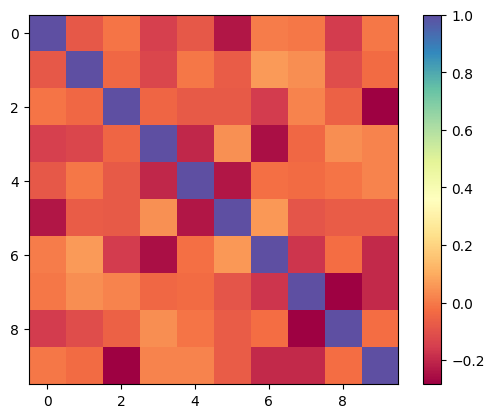

In [25]:
weights, bias = model.get_layer("last").get_weights()
print("Shape of the weights array:", weights.shape)
norms = []
for neuron in range(weights.shape[1]):
    norms += [np.linalg.norm(weights[:,neuron])]
weights /= norms

cos = np.matmul(weights.transpose(), weights)

plt.imshow(cos)
plt.set_cmap('Spectral')
plt.colorbar()
plt.show()

In [26]:
print(cos)

[[ 1.0000001  -0.07945745 -0.01135619 -0.1444983  -0.07812823 -0.2385075
   0.0042344  -0.0044607  -0.15674603 -0.00573175]
 [-0.07945745  1.0000002  -0.0393463  -0.12963131 -0.0029384  -0.07139783
   0.06489117  0.03723412 -0.10920479 -0.03072975]
 [-0.01135619 -0.0393463   1.         -0.04483627 -0.07528035 -0.07678553
  -0.15722485  0.02204275 -0.05322628 -0.2837088 ]
 [-0.1444983  -0.12963131 -0.04483627  0.99999994 -0.20074065  0.04412381
  -0.25094458 -0.03957643  0.03809351  0.01923133]
 [-0.07812823 -0.0029384  -0.07528035 -0.20074065  1.         -0.23464416
  -0.02292678 -0.03160782 -0.01260093  0.02034069]
 [-0.2385075  -0.07139783 -0.07678553  0.04412381 -0.23464416  1.0000001
   0.06059347 -0.08899517 -0.06960459 -0.06845124]
 [ 0.0042344   0.06489117 -0.15722485 -0.25094458 -0.02292678  0.06059347
   0.99999994 -0.17271711 -0.02484732 -0.19377773]
 [-0.0044607   0.03723412  0.02204275 -0.03957643 -0.03160782 -0.08899517
  -0.17271711  1.0000002  -0.28342554 -0.19511135]
 [

Which classes seem to be the most correlated? Would you have expected this?

**Answer**:

In first place, each class is most correlated to itself. It is the consequence of the cossine similarity:

$cos(\theta)=\frac{A.A}{||A|||A||}=1$

In second place, observing the plot, the following classes are correlated:

- 0 and 6
- 1 and 7
- 1 and 2
- 2 and 7


Probably, the correlation is related to the geometric forms that the manuscript digits could be presented.

A priori, I would expected some of those correlations (as 0 and 6 and 1 and 7) which were confirmed.


### Improving your network

Try to improve the performance of your network: try different numbers of layers (do not use convolutional layers yet), as well as the number of neurons per layer.

What is your best validation accuracy?

**Answer**:

The best validation accuracy (0.9755) is in the model B, as we can check in the cells output below.

In [27]:
# validate different architectures of models

modelA = Sequential()
modelA.add(Input(x_train.shape[1:]))
modelA.add(Dense(128, activation='relu'))
modelA.add(Dense(64, activation='relu'))
modelA.add(Dense(num_classes, activation='softmax', name="last"))

modelA.summary()

modelB = Sequential()
modelB.add(Input(x_train.shape[1:]))
modelB.add(Dense(128, activation='relu'))
modelB.add(Dense(64, activation='relu'))
modelB.add(Dense(32, activation='relu'))
modelB.add(Dense(num_classes, activation='softmax', name="last"))

modelB.summary()

modelC = Sequential()
modelC.add(Input(x_train.shape[1:]))
modelC.add(Dense(256, activation='relu'))
modelC.add(Dense(128, activation='relu'))
modelC.add(Dense(64, activation='relu'))
modelC.add(Dense(32, activation='relu'))
modelC.add(Dense(16, activation='relu'))
modelC.add(Dense(num_classes, activation='softmax', name="last"))

modelC.summary()

modelD = Sequential()
modelD.add(Input(x_train.shape[1:]))
modelD.add(Dense(32, activation='relu'))
modelD.add(Dense(64, activation='relu'))
modelD.add(Dense(128, activation='relu'))
modelD.add(Dense(64, activation='relu'))
modelD.add(Dense(num_classes, activation='softmax', name="last"))

modelD.summary()

models = [modelA, modelB, modelC, modelD]

def train_model(model, learning_rate, x_train2d=None, x_val2d=None):
  model.compile(loss='categorical_crossentropy',
                optimizer=SGD(learning_rate=learning_rate),
                metrics=['accuracy'])

  batch_size = 64
  epochs = 40
  lr = 0.01
  if x_train2d is not None:
    output = model.fit(x_train2d, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val),)
  else:
    output = model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_val, y_val),)

  return output



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ last (Dense)                         │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ last (Dense)                         │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,146 (434.16 KB)

 Trainable params: 111,146 (434.16 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ last (Dense)                         │ (None, 10)                  │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 244,890 (956.60 KB)

 Trainable params: 244,890 (956.60 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                     │ (None, 32)                  │          25,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ last (Dense)                         │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,458 (173.66 KB)

 Trainable params: 44,458 (173.66 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# train
learning_rate = 0.01
for model in models:
  output = train_model(model, learning_rate)
  print("\n\n")




Epoch 1/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5964 - loss: 1.4485 - val_accuracy: 0.8902 - val_loss: 0.4227
Epoch 2/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8920 - loss: 0.4018 - val_accuracy: 0.9113 - val_loss: 0.3189
Epoch 3/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9100 - loss: 0.3234 - val_accuracy: 0.9248 - val_loss: 0.2766
Epoch 4/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9186 - loss: 0.2848 - val_accuracy: 0.9348 - val_loss: 0.2502
Epoch 5/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9259 - loss: 0.2617 - val_accuracy: 0.9370 - val_loss: 0.2324
Epoch 6/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9325 - loss: 0.2383 - val_accuracy: 0.9420 - val_loss: 0.2148
Epoch 7/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9367 - loss: 0.2212 - val_accuracy: 0.9472 - val_loss: 0.2031
Epoch 8/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9418 - loss: 0.2059 - val_accuracy: 0.

### Testing

Testing is the last stage of the learning process. Good practice recommends to do it only once, when you have completely finished with the optimization of the network parameters and hyperparameters.

In [29]:
best_model = modelB
score = best_model.evaluate(x_test, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

Test loss: 0.084
Test accuracy: 0.973


### Confusion matrix

Each value $C_{i,j}$ of the confusion matrix $C$ gives the number of elements known to belong to class $i$ that have been classified in class $j$.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 640x480 with 0 Axes>

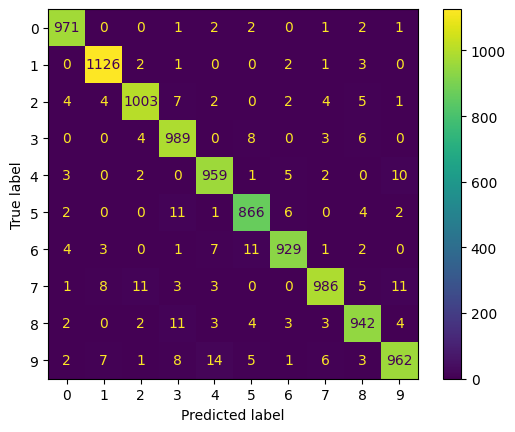

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_proba = modelB.predict(x_test)
y_pred = y_pred_proba.argmax(axis=-1)

plt.clf()

ConfusionMatrixDisplay.from_predictions(y_test_ori, y_pred)
# show the confusion matrix
plt.show()

Which pair of classes causes the most confusion? Is it coherent with the analysis of the cosine similarity between neurons of the last layer? Why?

**Answer**: The biggest confusion is caused between 3 (predicted label) and 5 (true label), with 18 wrong classifications.

In the analysis of the cossine similarities, there was a certain similarity between those classes, but they weren't the most similar (1 and 7 for example were more similar by cossine similirity than 3 and 5).

## Using Convolutional Layers

In order experiment with convolutional networks and see their benefits, we can now use convolutional layers.

<u>Formatting input: </u>: since we are going to use convolutional layers we need image data. We can map images back to their original domain in a 28 x 28 grid

In [31]:
x_train_2d = x_train.reshape([-1,28,28,1])
x_val_2d = x_val.reshape([-1,28,28,1])
x_test_2d = x_test.reshape([-1,28,28,1])

Here we will implement our first convolutional neural network. Using keras `Sequential` API, build a CNN with the following sequential architecture:

        - Conv2D: 16 filters and a kernel of size (5x5), ReLU activation
        - MaxPooling2D
        - Conv2D: 32 filters and a kernel of size (3x3), ReLU activation
        - MaxPooling2D
        - Conv2D: 32 filters and a kernel of size (3x3), ReLU activation
        - MLP: 128 neurons, ReLU activation
        - MLP: num_classes neurons
        - Softmax activation

Dont forget, we are now working with images but the MLP layers only takes 1D vector as input.

Use `help(Conv2D)`, etc.. directly in a cell to access the layers API or directly check on [keras](https://keras.io/api/)

In [32]:
x_train_2d.shape


(54000, 28, 28, 1)

In [33]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten

model = Sequential()
model.add(Input(x_train_2d.shape[1:]))
model.add(Conv2D(15, (5,5), activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))


model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 24, 24, 15)          │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 15)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 32)          │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,272 (204.19 KB)

 Trainable params: 52,272 (204.19 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
learning_rate = 0.01
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=learning_rate),
              metrics=['accuracy'])

In [35]:
batch_size = 64
epochs = 40
output = model.fit(x_train_2d, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val_2d, y_val),
)

Epoch 1/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3499 - loss: 1.8707 - val_accuracy: 0.9017 - val_loss: 0.3237
Epoch 2/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9082 - loss: 0.3052 - val_accuracy: 0.8977 - val_loss: 0.3282
Epoch 3/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9471 - loss: 0.1767 - val_accuracy: 0.9657 - val_loss: 0.1198
Epoch 4/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9616 - loss: 0.1261 - val_accuracy: 0.9693 - val_loss: 0.1027
Epoch 5/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9690 - loss: 0.1023 - val_accuracy: 0.9743 - val_loss: 0.0827
Epoch 6/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9722 - loss: 0.0903 - val_accuracy: 0.9765 - val_loss: 0.0787
Epoch 7/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9754 - loss: 0.0802 - val_accuracy: 0.9803 - val_loss: 0.0708
Epoch 8/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9781 - loss: 0.0734 - val_accuracy: 0.

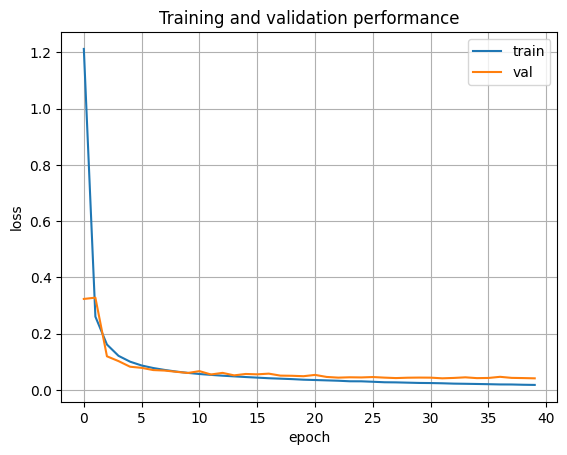

In [36]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(output.epoch, output.history['loss'], label='train')
plt.plot(output.epoch, output.history['val_loss'], label='val')
plt.title('Training and validation performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()
# plt.ylim(0.2, 0.8)

Is it overfitting? What can you say about it when you compare with the denser architecture?
What else can you do to reduce it?

**Answer:**

To reduce overfitting, we could:

- Use less epochs in trainning phase
- Use regularization techniques, such as dropout, L1 or L2 regularization

Comparing to the denser architecture, the CNN model has a better performance, with a validation accuracy of 0.9895, while the denser model had a validation accuracy of 0.9755 (model B).

In [37]:
score = model.evaluate(x_test_2d, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

Test loss: 0.031
Test accuracy: 0.991


# Visualizing the Feature Maps

We can try to understand what is happening in the network by looking at its feature maps. Since they are defined on a grid, we can vizualize them as images.

Here we vizualize the feature maps of the first layer for some images.

15


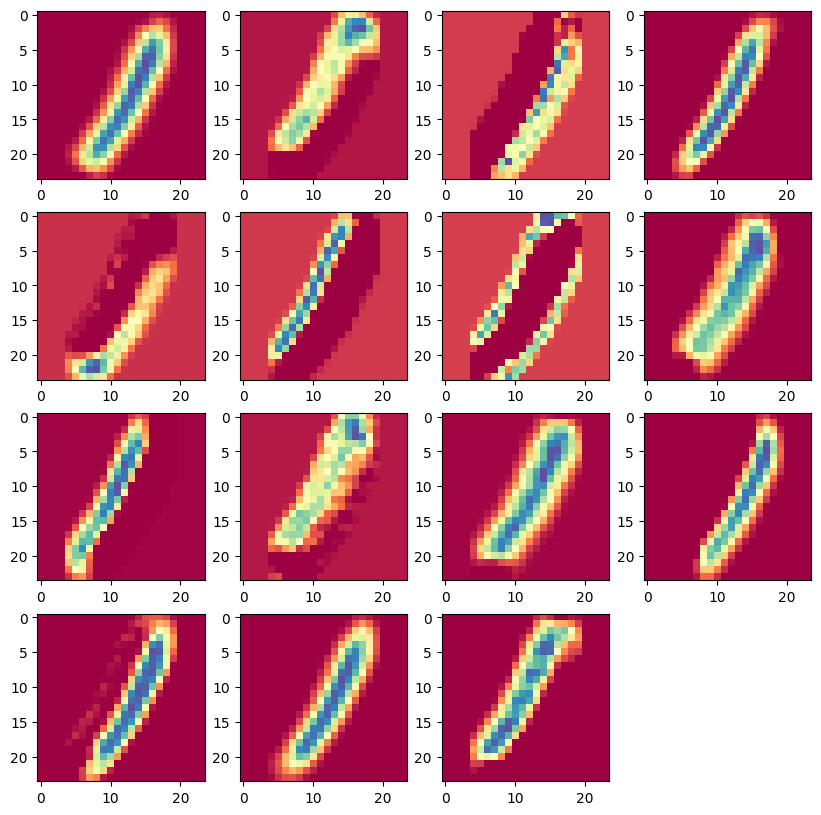

In [38]:
%matplotlib inline

im = x_test_2d[np.random.randint(0, x_test_2d.shape[0]), :, :, :]
im = im[np.newaxis, ...]
fmaps = model.layers[0](im)

plt.figure(figsize=(10,10))
# for i in range(16):
num_channels = fmaps.shape[-1]
print(num_channels)
for i in range(min(16, num_channels)):
    plt.subplot(4,4,i+1)
    plt.imshow(fmaps[0,:,:,i])

15


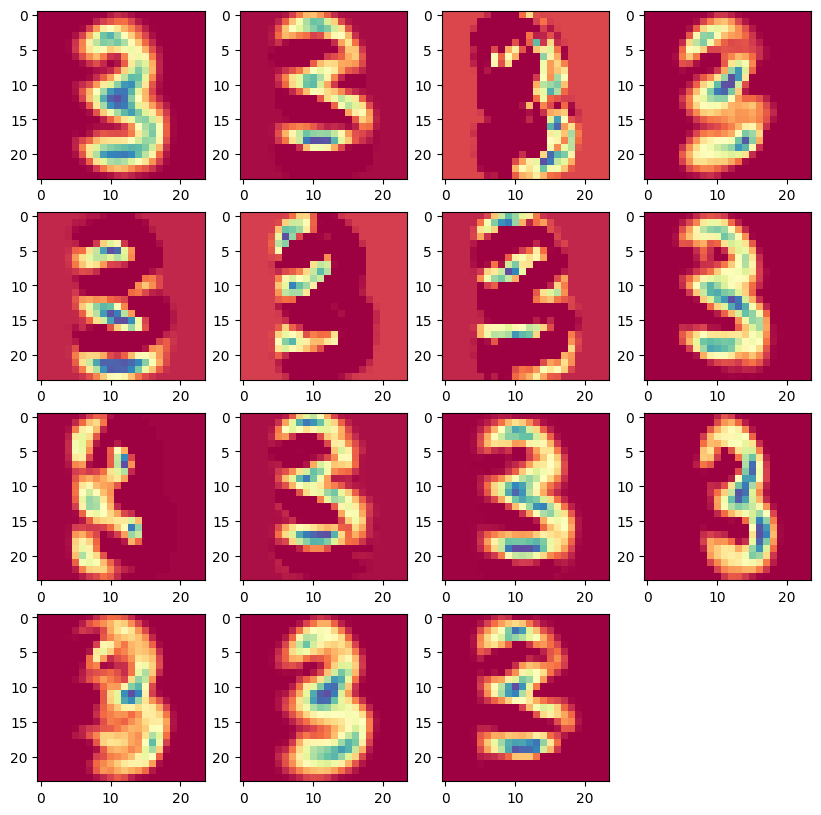

In [39]:
%matplotlib inline

im = x_test_2d[np.random.randint(0, x_test_2d.shape[0]), :, :, :]
im = im[np.newaxis, ...]
fmaps = model.layers[0](im)

plt.figure(figsize=(10,10))
num_channels = fmaps.shape[-1]
print(num_channels)
for i in range(min(16, num_channels)):
    plt.subplot(4,4,i+1)
    plt.imshow(fmaps[0,:,:,i])

Can you identify if the convolutional layer detects meaningful features?(for example edges and corners)

**Answer:**

Yes, the first convolutional layer, which counts with 15 channels, is detecting edges of the digits 1 and 3 through each channel, as we can see above.

# Improving your network

As before, try to improve your network by changing the number of layers of each type and the number of feature maps, neurons or kernel size.

**Answer**

Here,as GPU is limited, instead of trainning with all those different configurations, I chose to test different values of kernel sizes (3,3) and (4,4).

In [40]:
kernel_sizes = [(3,3), (4, 4)]
models = []

for kernel_size in kernel_sizes:
  model = Sequential()
  model.add(Input(x_train_2d.shape[1:]))
  model.add(Conv2D(15, kernel_size, activation='relu'))
  model.add(MaxPool2D())
  model.add(Conv2D(32, kernel_size, activation='relu'))
  model.add(MaxPool2D())
  model.add(Conv2D(32, kernel_size, activation='relu'))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  models.append(model)
  model.summary()

def train_2dmodel(model, learning_rate):
  model.compile(loss='categorical_crossentropy',
                optimizer=SGD(learning_rate=learning_rate),
                metrics=['accuracy'])

  batch_size = 64
  epochs = 40
  lr = 0.01
  output = model.fit(x_train_2d, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_val_2d, y_val),)
  return output

for model in models:
  output = train_2dmodel(model, learning_rate)
  print("\n\n")

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 15)          │             150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 15)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 32)          │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,032 (203.25 KB)

 Trainable params: 52,032 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 25, 25, 15)          │             255 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 12, 12, 15)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 9, 9, 32)            │           7,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 1, 1, 32)            │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,897 (116.79 KB)

 Trainable params: 29,897 (116.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4321 - loss: 1.7675 - val_accuracy: 0.8995 - val_loss: 0.3298
Epoch 2/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9014 - loss: 0.3209 - val_accuracy: 0.9398 - val_loss: 0.2025
Epoch 3/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9356 - loss: 0.2067 - val_accuracy: 0.9482 - val_loss: 0.1689
Epoch 4/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9504 - loss: 0.1615 - val_accuracy: 0.9615 - val_loss: 0.1281
Epoch 5/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9599 - loss: 0.1295 - val_accuracy: 0.9672 - val_loss: 0.1097
Epoch 6/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9666 - loss: 0.1084 - val_accuracy: 0.9697 - val_loss: 0.0978
Epoch 7/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9696 - loss: 0.0974 - val_accuracy: 0.9708 - val_loss: 0.0900
Epoch 8/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9741 - loss: 0.0865 - val_accuracy: 0.


What is your best validation accuracy?

**Answer**: The best validation accuracy is obtained in the first model (kernel = 3x3), with 0.9878,

# Optional: Experimenting with a more complex database

We will now move to the fashion MNIST database, in order to experiment with a more complex database. The best test accuracy reported on this database is 0.967 (see https://github.com/zalandoresearch/fashion-mnist).



In [41]:
from tensorflow.keras.datasets import fashion_mnist as db

# Import necessary libraries
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

# You can use the following dictionary to transform number labels into meaningful labels:
fashion_dict = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
    }

print(fashion_dict[2])

Pullover


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


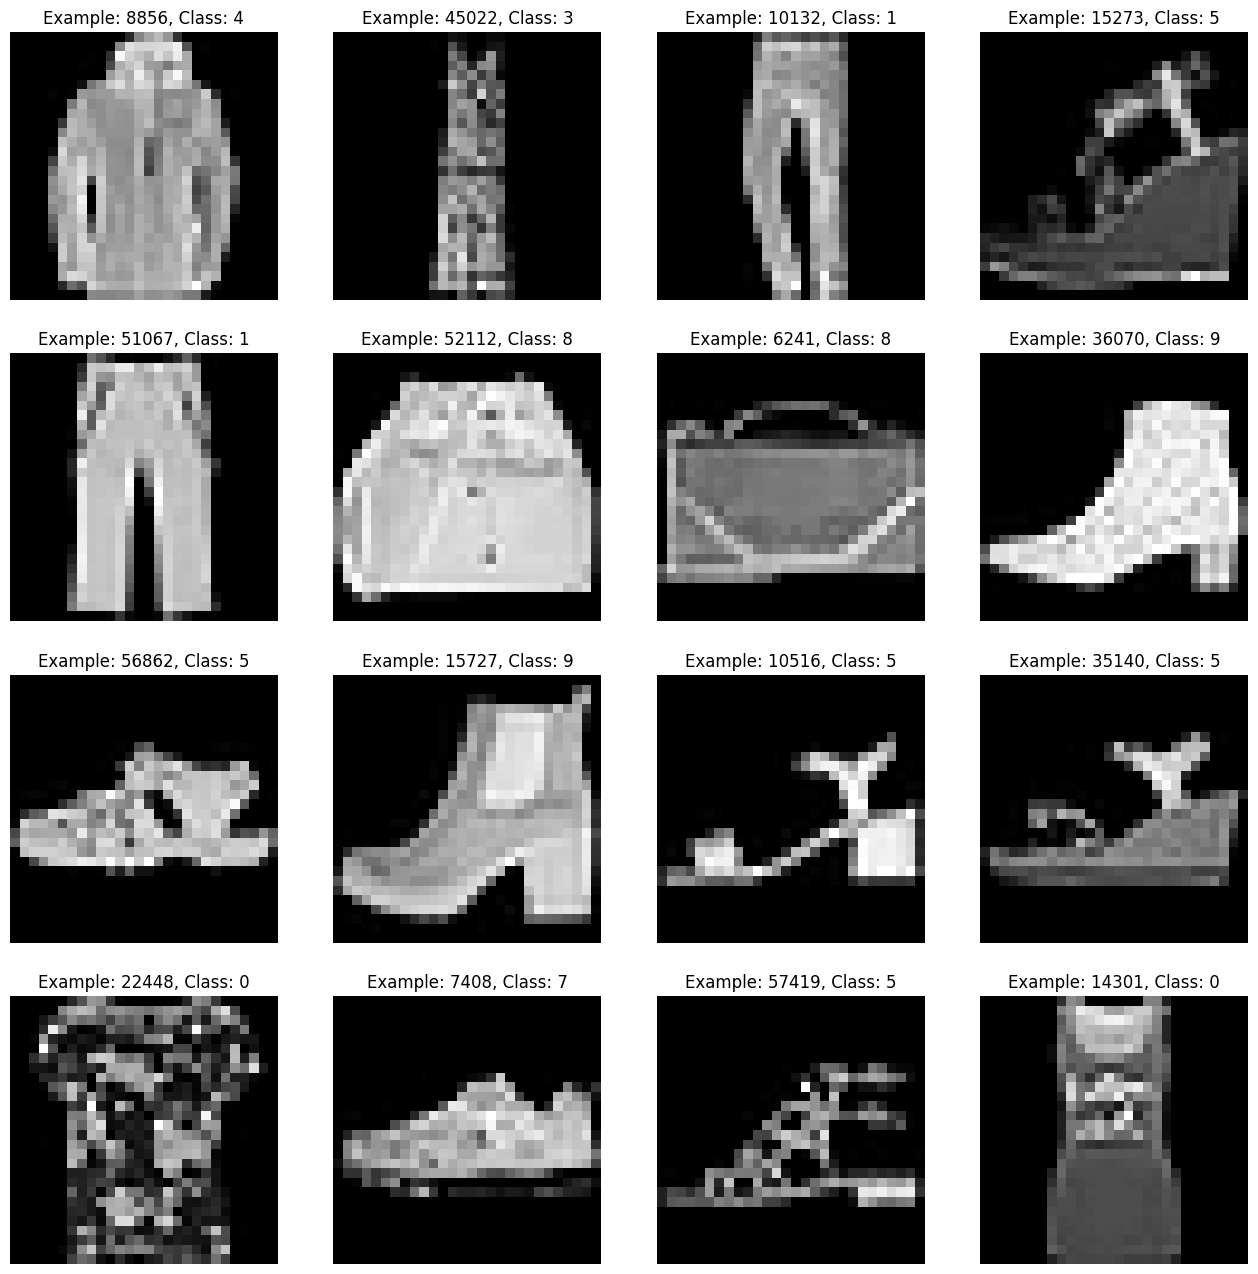

In [42]:
# Load and have a look at the data
(x, y), (x_test_ori, y_test_ori) = db.load_data()

# Visualize a single digit, with its class
plt_r,plt_c = 4,4
f, ax = plt.subplots(plt_r, plt_c, figsize=(16,16))
for i in range(plt_r):
    for j in range(plt_c):
        index = np.random.randint(x.shape[0])
        ax[i][j].imshow(x[index], cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].set_title("Example: {}, Class: {}".format(index, y[index]))
plt.show()

Build your own model below, train it on the fashion MNIST database and analyse its results. Dont forget to normalize and put the data into the correct format. Try to reach the highest validation accuracy. Finally, evaluate it using the test database.

You must respect the following constraints:

* you can use dense, convolutional, and pooling layers in your network;

* do not change the optimizer, the loss or the metrics used during training.



In [53]:

x_val_rate = 0.2
x_val = x_train[:int(x_train.shape[0]*x_val_rate)]
y_val = y_train[:int(y_train.shape[0]*x_val_rate)]
x_train = x_train[int(x_train.shape[0]*x_val_rate):]
y_train = y_train[int(y_train.shape[0]*x_val_rate):]


# Define the model parameters
kernel_size = (3, 3)
num_classes = 10

# Build the model
model = Sequential()
model.add(Input(shape=(28, 28, 1)))  # Correct input shape for Conv2D
model.add(Conv2D(15, kernel_size, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, kernel_size, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, kernel_size, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Summarize the model
model.summary()

model.compile(loss=categorical_crossentropy,
              optimizer=SGD(learning_rate=learning_rate),
              metrics=['accuracy'])

batch_size = 64
epochs = 40
output = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val, y_val),)



Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 26, 26, 15)          │             150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 13, 13, 15)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 11, 11, 32)          │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 3, 3, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 128)                 │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,032 (203.25 KB)

 Trainable params: 52,032 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.3340 - loss: 1.9926 - val_accuracy: 0.6519 - val_loss: 0.9278
Epoch 2/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6863 - loss: 0.8421 - val_accuracy: 0.7340 - val_loss: 0.7252
Epoch 3/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7408 - loss: 0.7025 - val_accuracy: 0.7565 - val_loss: 0.6721
Epoch 4/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7667 - loss: 0.6296 - val_accuracy: 0.7625 - val_loss: 0.6110
Epoch 5/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7853 - loss: 0.5763 - val_accuracy: 0.7925 - val_loss: 0.5628
Epoch 6/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8013 - loss: 0.5347 - val_accuracy: 0.7976 - val_loss: 0.5401
Epoch 7/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8082 - loss: 0.5176 - val_accuracy: 0.7994 - val_loss: 0.5289
Epoch 8/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8232 - loss: 0.4890 - val_accuracy: 0.

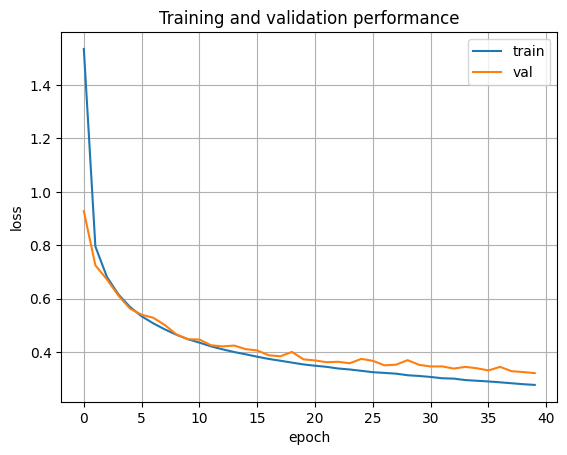

In [55]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(output.epoch, output.history['loss'], label='train')
plt.plot(output.epoch, output.history['val_loss'], label='val')
plt.title('Training and validation performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()


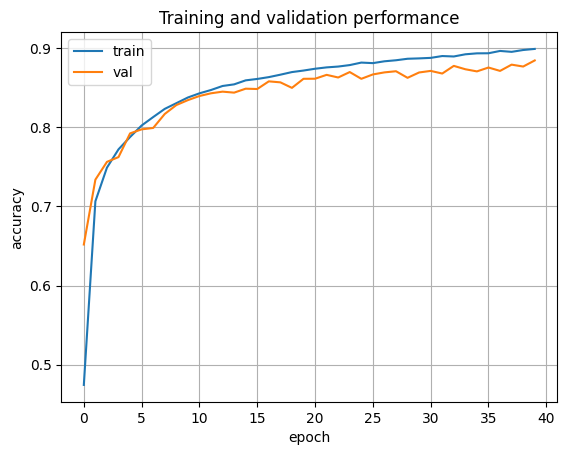

In [56]:
fig, ax = plt.subplots()
plt.plot(output.epoch, output.history['accuracy'], label='train')
plt.plot(output.epoch, output.history['val_accuracy'], label='val')
plt.title('Training and validation performance')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()


In [54]:
# test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

Test loss: 0.339
Test accuracy: 0.882


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<Figure size 640x480 with 0 Axes>

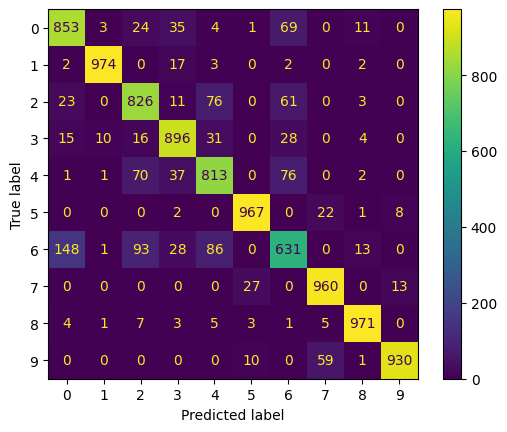

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_proba = model.predict(x_test)
y_pred = y_pred_proba.argmax(axis=-1)

plt.clf()

ConfusionMatrixDisplay.from_predictions(y_test_ori, y_pred)
plt.show()


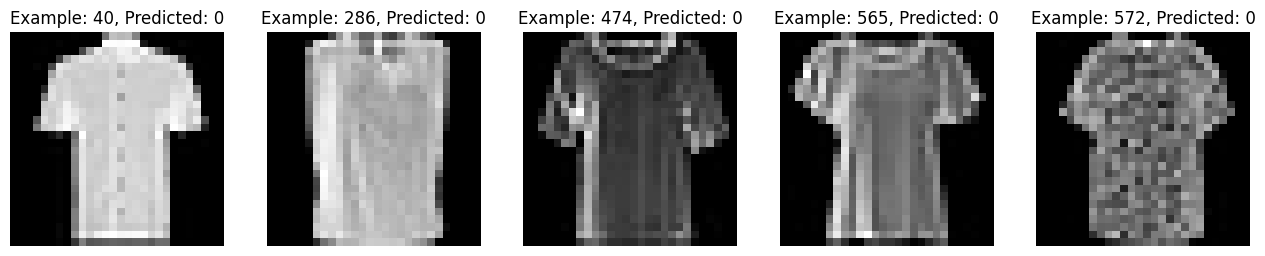

In [62]:
# plot the class 6 that are confused with class 0
class_6_true = np.where(y_test_ori == 6)[0]
class_0_pred = np.where(y_pred == 0)[0]
class_6_0 = np.intersect1d(class_6_true, class_0_pred)

# print the top 5 images in a row
plt_r,plt_c = 1,5
f, ax = plt.subplots(plt_r, plt_c, figsize=(16,16))
for i in range(plt_c):
    index = class_6_0[i]
    ax[i].imshow(x_test_ori[index], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title("Example: {}, Predicted: {}".format(index, y_pred[index]))
plt.show()


# Your results on the fashion MNIST database

Which pairs of classes are the main cause of confusion?

**Answer**: The classes 6 (True label) and 0 (Predicted label) causes the main confusion. In second place, the classes 6 (true label) and 2 causes confusion as well.


Did you use an architecture different than the one used for MNIST? If so, how?

**Answer**: I used the same architecture for MNIST, but used the best kernel size (3x3) found there. Due to GPU limitations, I could not test different configurations for the Fashion MNIST.


Is there overfitting?

**Answer**: There is no overfitting, as the validation loss and accuracy continues to improve, as one can see on the graph.

**Test accuracy**: 88.2%